# Downloading all bonds ever owned in CSPP

All bonds are downloaded from the CSPP website. They are saved to an excel file for easy retrieval and saved to a dataframe for analysis in this notebook.

In [1]:
from functions import downloadECBBonds

In [2]:
holdingsECB = downloadECBBonds.download_ECB_Bonds()

# Read all the Eikon data

Additional data on the bonds from the EIKON database was downloaded and saved to .txt files, which are imported here. There was also a list of eligible bonds in this database. The same data for these bonds was downloaded and is imported as well.

In [3]:
from functions import readEikonData
eikon_data_complete = readEikonData.get_eikon_data_complete()
eligible_complete = readEikonData.get_data_eligible_complete() # read all data from eligible universe

Some bonds bought by the ECB are also mentioned in the eligible universe. The percentage of bonds appearing in both sets is calculated here. 

In [4]:
overlap = eikon_data_complete[(eikon_data_complete["ISIN"].isin(eligible_complete["ISIN"]))]
print("the percentage of bonds bought by ECB in eligible universe that we have info on:    ", 
      overlap.shape[0]/eligible_complete.shape[0])

the percentage of bonds bought by ECB in eligible universe that we have info on:     0.16143170197224252


The date that a bond is bought by the ECB is also of interest. This is saved to a dataframe with the following function.

In [5]:
years_issuer_bought = readEikonData.get_dates_data_frame()

# Green Bond Analysis based on EIKON green bond flags

The EIKON database is compared with the Euronext database to check which has the most information on green bonds.

In [6]:
from functions import greenbonds
greenbonds.compareGreenbondsEuronextvsEIKON()

c:\Users\Maarten\OneDrive\school\2020-2021\bMLSOD\Modern Data Analytics\project\ECB-Bond-Purchases\functions\greenbonds.py:11: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  euronext_greenbonds = pd.read_excel(data_folder + "Euronext-Green-Bond-List.xlsx", header=0)
Euronext greenbonds: 65 vs EIKON greenbonds: 117


It appears that EIKON has the most green bond flags, so this data is used in the rest of this section. The number of green bonds bought in a year can now be compared with the total number of bonds bought in that same year.

In [7]:
greenbonds.get_percentages_greenbonds_on_bonds_per_year()

,year,percentage
0,2017,3.696099
1,2018,5.583756
2,2019,14.788732
3,2020,8.353808
4,2021,14.705882


A graphical representation of this table is made here.

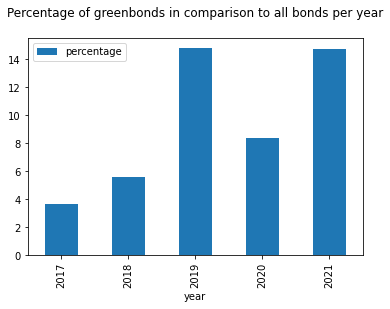

In [8]:
greenbonds.draw_spaghetti_plot_greenbonds()

# Company Analysis based on ESG scores

## Cleaning ESG Data
The ESG data retrieved from the EIKON database is cleaned first. The functions returns the number of bonds that have no ESG data available, and how many had missing data that is filled in using linear interpolation.

In [9]:
from functions import ESG
print("for eligible universe:")
esg_company_data_eligible = ESG.cleaning_esg_data(eligible_complete)
print("for holdings in the CSPP:")
esg_company_data_holdings = ESG.cleaning_esg_data(eikon_data_complete)

for eligible universe:
nb of rows without ESG scores:  139
percentage of rows without ESG scores:  0.6405529953917051
nb of nans filled in using interpolation:  152
percentage of nans filled in using interpolation:  0.08755760368663594
for holdings in the CSPP:
nb of rows without ESG scores:  216
percentage of rows without ESG scores:  0.5837837837837838
nb of nans filled in using interpolation:  266
percentage of nans filled in using interpolation:  0.08986486486486486


## ESG Evolution of holdings through the years
The data on the ESG scores of the ECB's holdings is split up per year (based on when they first appeared in the weekly overview) and compared with the evolution of the ESG scores of the companies selling bonds eligible for purchase by the ECB. 

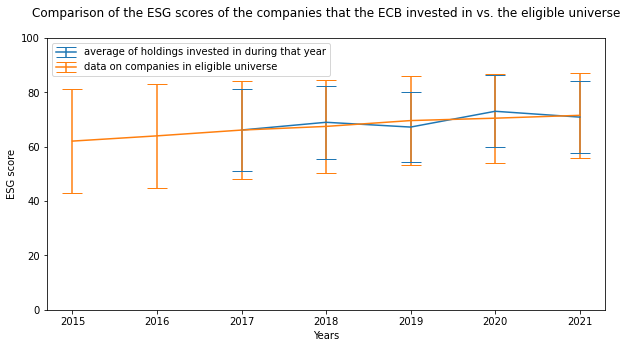

In [10]:
ESG.average_company_esg_score_plot(years_issuer_bought, esg_company_data_holdings,esg_company_data_eligible)

# Sector Analysis based on PermID sector data

## Get all sector data from PermID
The PermID API is used to retrieve information on the sector and industry to which the bonds belong.

In [11]:
from functions import permidSectors
sector_mappings = permidSectors.get_sector_mappings(holdingsECB)
sector_mappings.dropna(inplace = True)

c:\Users\Maarten\OneDrive\school\2020-2021\bMLSOD\Modern Data Analytics\project\ECB-Bond-Purchases\functions\permidSectors.py:122: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  sector_mappings = pd.read_excel(parent+'\output\sector_mappings_data.xlsx', header=0)


## Represent industries and sectors

Create a pie chart to represent the number of times an industry, sector or supersector is present in the data (multiple bonds for the same company are counted separately)

In [12]:
from functions import pieCharts

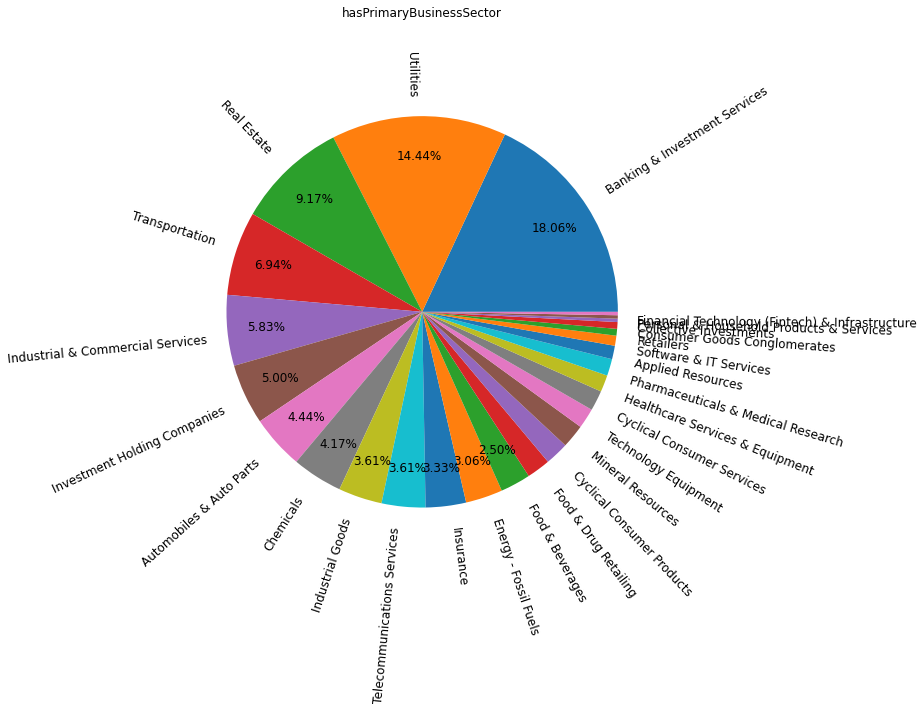

In [13]:
pieCharts.make_pie_chart('hasPrimaryBusinessSector', sector_mappings)

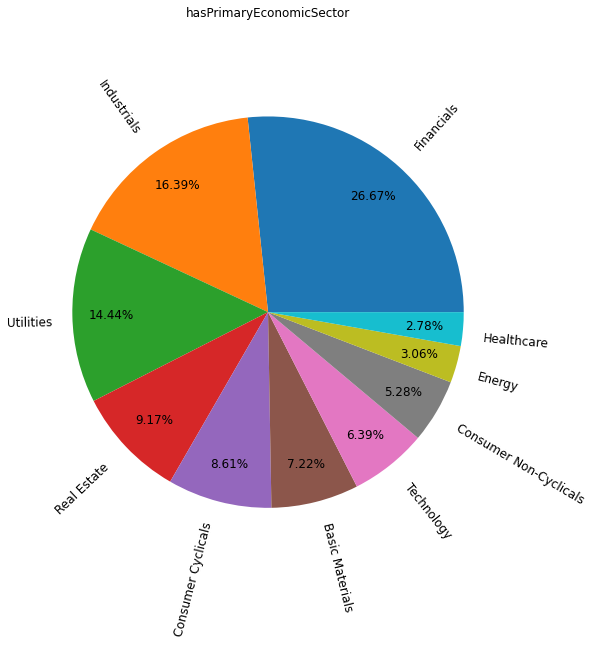

In [14]:
pieCharts.make_pie_chart('hasPrimaryEconomicSector', sector_mappings)

## Which industries and sectors are green?

We made a dictionary containing all the sectors and a value that represents whether we think they are green, neutral, or grey. This dictionary with greenness of all PermID sectors is mapped with the ones in which ECB invested.

In [15]:
from functions import sectors
sector_green_dict = sectors.get_sector_green_dict()

primary_business_sector = pieCharts.get_all_sectors("hasPrimaryBusinessSector", sector_mappings)
primary_business_sector = sectors.map_green_dict_to_data_frame(primary_business_sector)
sector_mappings["Greenness"] = sector_mappings["hasPrimaryBusinessSector"].dropna().apply(lambda x: sector_green_dict[x])

sectors.set_global_sector_variables(primary_business_sector, sector_mappings, years_issuer_bought)

A spaghetti plot is now created to compare the evolution of bonds bought by the ECB, grouped by there greenness according to our dictionary.

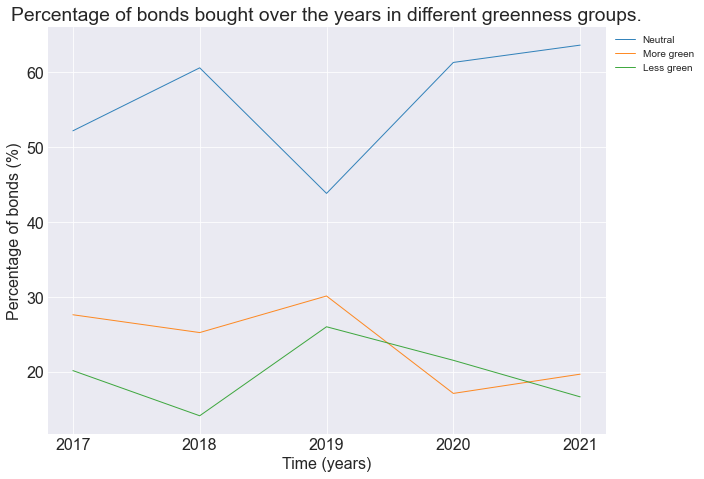

In [16]:
# Drawing a sphagetti plot by grouping sectors according to greenness
sectors.draw_spaghetti_plot_with_grouped_sectors()

Here, an interactive graph is created using a widget. The sectors of interest can be selected, to allow an easy comparison.

In [17]:
sectors.display_widget()

Button(description='Select all', style=ButtonStyle())

Output()